### Full Text Analysis: Author Similarity
##### Author: Alex Oesterling, Rui Xin (Parsing cells at beginning).

In this notebook, I investigate overlap in citing and cited authors using the full text. This gives me access to authors beyond the first author on a paper for use. In addition, I look at the ratio of where a citing author occurs in the text.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from pprint import pprint
import sys
sys.path.insert(1, "../../Utilties")
from metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Load Data


In [2]:
# Start by defining the file relative path of this dataset. 
train_file_name = "../../Data/train.csv"
val_file_name = "../../Data/val.csv"
test_file_name = "../../Data/test.csv"
total_file_name = "../../Data/totaldata.csv"

# # Read in the data, use unicode_escape in order to successfully encode the data. 
df = pd.read_csv(train_file_name, encoding= 'unicode_escape')
totdf = pd.read_csv(total_file_name, encoding='unicode_escape')

# File path for full text files
FULL_TEXT_FOLDER = '../../Data/full_text/'


## Partition Article into Sections


In [3]:
import re

SECTION_KEYWORDS = ['Abstract', 'Introduction', 'Background', 'Related Work', 'Method', 'Result', 'Conclusion', 'Reference', 'Discussion', 'References', 'Bibliography',"Literature Cited", 'Acknowledgment', 'Appendix']

# 'Keyword', 'Content',

# Allow for all caps versions of keywords
section_keywords_selector = r'(?:%s)' % '|'.join(list(
    map(lambda x: x.replace(' ', r'\s*?'), 
        SECTION_KEYWORDS + list(map(lambda x: x.upper(), SECTION_KEYWORDS))) 
))

section_selector = (r'(%s)[Ss]?\s*[^a-z\s\-()]' % section_keywords_selector) 

section_re = re.compile(section_selector, flags = re.S)

section_selector

'((?:Abstract|Introduction|Background|Related\\s*?Work|Method|Result|Conclusion|Reference|Discussion|References|Bibliography|Literature\\s*?Cited|Acknowledgment|Appendix|ABSTRACT|INTRODUCTION|BACKGROUND|RELATED\\s*?WORK|METHOD|RESULT|CONCLUSION|REFERENCE|DISCUSSION|REFERENCES|BIBLIOGRAPHY|LITERATURE\\s*?CITED|ACKNOWLEDGMENT|APPENDIX))[Ss]?\\s*[^a-z\\s\\-()]'

In [4]:
# Clustering by thresholding percentage delta
# Returns a list of clusters
# TODO: handle the case when abstract and introduction are merged together 
def cluster_section(text):
    lines = text.split('\n')

    length = list(map(len, lines))
    thres = 0.2

    clusters = []
    cluster = []
    twoNextInThres = False
    st = -1
    fi = -1
    for i in range(len(length) - 1):
        if i < fi - 1: continue
        nextInThres = abs((length[i] - length[i + 1]) / (length[i] + 1)) < thres
        # Allow one line of error as extraction result usually includes footers and stuff
        # that's not in the text
        twoNextInThres = i < len(length) - 2 and abs((length[i] - length[i + 2]) / (length[i] + 1)) < thres
        
        # Some articles have their paragraphs in a single line
        if length[i] > 300:
            clusters.append(lines[i:i+1])
        # If a line is too short, we consider it as the end of a cluster
        elif length[i] < 20:
            nextInThres = False
            twoNextInThres = False
        if st == -1 and nextInThres:
            st = i
        if nextInThres:
            fi = i + 2
        elif twoNextInThres:
            fi = i + 3
        elif st > -1:
            fi += 1
            clusters.append(lines[st:fi])
            st = -1
    if clusters is None:
        return [text]
    return clusters


In [5]:
re1 = re.compile(r'-\s+')
re2 = re.compile(r'\s+')
def collapse_lines(text):
    text = re1.sub('', text)
    text = re2.sub(' ', text)
    return text


In [6]:
coreid2Article = {}

def process_article(core_id):
    if coreid2Article.get(core_id): return coreid2Article.get(core_id)

    full_text_file = '%s%s.txt' % (FULL_TEXT_FOLDER, core_id)
    with open(full_text_file, encoding='utf-8') as f:
        full_text = f.read()

    # Stores where the slices are 
    sectionsIdx = []
    
    # Map each slice into corresponding section type
    idx2Sec = {}
    
    # Store the actual text of a section
    sec2Txt = {}

    # Slice the entire article based on matches. The beginning of each match
    # must contain the type of the section, and set the range of the section 
    # till the beginning of a new one or the end of the article
    for match in section_re.finditer(full_text):
        
        section = match.group(1).lower()
        ##added by alex:
        if section == "bibliography" or section == "literature cited" or section == 'references' or section == 'conclusion':
            section = "reference"
        ##end add
        sectionsIdx.append(match.span()[-1])
        idx2Sec[match.span()[-1]] = section

    sectionsIdx.append(len(full_text))

    for i in range(len(sectionsIdx) - 1):
        secTxt = full_text[sectionsIdx[i] : sectionsIdx[i + 1]]
        if sec2Txt.get("reference") is None:
            if not sec2Txt.get(idx2Sec[sectionsIdx[i]]):
                # If a section does not exist, simpily set the text to be the section text
                sec2Txt[idx2Sec[sectionsIdx[i]]] = secTxt
            else: 
                # If a section already exists, then merge this section with the one with the same name
                sec2Txt[idx2Sec[sectionsIdx[i]]] += secTxt
                idx2Sec[sectionsIdx[i]] = idx2Sec[sectionsIdx[i - 1]]
        else:
            sec2Txt["reference"] += secTxt
            
    # Some articles might not have abstracts, so we set the beginning of the article to abstract
    if not sec2Txt.get('abstract'):
        sec2Txt['abstract'] = full_text[: sectionsIdx[0]]

    # The beginning of an article is usually messy as it includes authors, contact info, etc. 
    # So, we need to extract a paragraph

    abstract_clusters = cluster_section(sec2Txt['abstract'])
    abstract_lens = list(map(len, map(' '.join, abstract_clusters)))
    if(len(abstract_lens) == 0):
        print(abstract_clusters)
    longest_cluster = '\n'.join(abstract_clusters[abstract_lens.index(max(abstract_lens))])

    # If the "abstract" is obviously too long (greater than 10% of the entire article), 
    # then divide them into different parts
    if len(sec2Txt['abstract']) / len(full_text) > 0.10:
        cluster_lens = list(map(lambda cluster: sum(map(len, cluster)) / len(cluster), abstract_clusters))
        line_lens = list(map(lambda cluster: list(map(len, cluster)), abstract_clusters))
        line_lens = [item for sublist in line_lens for item in sublist]
        
        median_len = np.median(line_lens)
        for i in cluster_lens:
            if abs(i - median_len) / median_len < 0.2:
                idx = max(1, cluster_lens.index(i))
                if idx < len(cluster_lens):
                    extra_content = sec2Txt['abstract'][sec2Txt['abstract'].index(abstract_clusters[idx][0]):]
                    if 'introduction' not in sec2Txt:
                        sec2Txt['introduction'] = ''
                    sec2Txt['introduction'] += extra_content
                    abstract_lens = abstract_lens[:idx]
                break
        sec2Txt['abstract'] = '\n'.join(abstract_clusters[abstract_lens.index(max(abstract_lens))])

    else:
        sec2Txt['abstract'] = longest_cluster

    # Remove all new line symbol and also dashes at the end of a line
    for sec in sec2Txt:
        sec2Txt[sec] = collapse_lines(sec2Txt[sec])
        
    sec2Data = {}
    for sec in sec2Txt:
        sec2Data[sec] = {}
        sec2Data[sec]['text'] = sec2Txt[sec]
        sec2Data[sec]['sent'] = nltk.tokenize.sent_tokenize(sec2Txt[sec])
        
    article = {}
    article['sections'] = sec2Data
    article['full_text'] = collapse_lines(full_text)

    coreid2Article[core_id] = article
    return article

In [7]:
for core_id in tqdm(df['core_id']):
    process_article(core_id)

100%|█████████████████████████████████████████████████████████████████████████████| 2528/2528 [00:08<00:00, 294.78it/s]


### After processing all the articles, my goal is to determine co-author overlap.

What I need to do is the following:
* Find citing author from full data UID lookup
* Iterate through citation contexts from full data, and look them up in references (by title)
* See whether authors attributed to that title include citing author

Notes on finding author and citation in reference raw text:
* The training data omits colons, but they are present in the raw text. I remove spaces and punctuation from the full text and filter the titles similarly so I can detect them in the reference text.
* Looks like splitting and searching up to 2 numbers in front of title is a good methodology. Split at numbers using regex, and generally within the last 3 entries before the citation title the author list is found.

Known issues:

2085983, 2068614- Author is called "extracted" (first author citation) - CC2089, 2564, and 1335

41769583 - More than 2 numbers to authors when splitting

CC2463 and
CC2464 - Poor transcription of title text. Fix?
CC325 - Legit just the wrong author

In [8]:
coauthors = []
firstauthors = []
positions = []
for i, uniqueid in enumerate(totdf["unique_id"].values):
    UID = totdf.core_id.values[i]
    fullname = totdf.citing_author.values[i].split(" ")
    citing_author = fullname[1] + fullname[0][0]
    cleanedcitingauthor = re.sub(r'[^\w\s+]','',citing_author)
    cleanedcitinglast = re.sub(r'[^\w\s+]','', fullname[1])
    article = coreid2Article[UID]
    
    cited_title = totdf["cited_title"].values[i]
    cleanedcitedauthor = re.sub(r'[^\w\s+]','',totdf["cited_author"].values[i])
    regtitle =  re.sub(r'[^\w]','',cited_title[0:24])
    
    if cleanedcitinglast == cleanedcitedauthor:
        coauthors.append(1)
        firstauthors.append(1)
        continue
    elif "reference" in article["sections"].keys():
        firstauthors.append(0)
        fulltext = article["sections"]["reference"]["text"]
        regterm = re.sub(r'[^\w]','',fulltext)
        splitstring = regterm.split(regtitle)
        splits = re.split('(\d+)', splitstring[0])
        if(cleanedcitingauthor in "".join(splits[-3:])):
            if cleanedcitinglast not in totdf["cited_author"].values[i]:
                print("Detected but not first author: ", end="")
                print(" Citing Author: " + citing_author, end="")
                print(" First Author: " + totdf["cited_author"].values[i])
                print(totdf["citation_influence_label"].values[i])
                print(totdf["citation_context"].values[i])
                print(" = = = = ")
            coauthors.append(1)
            continue
        else:
            coauthors.append(0)
            continue
    else:
        print("Failed to find: ")
        coauthors.append(0)
        firstauthors.append(0)

Detected but not first author:  Citing Author: ThanapalasingamT First Author: Osborne
1
It works according to three main steps:1) It represents journals, books, and conferences according to the metadata of their chapters/articles and uses the Smart Topic API #AUTHOR_TAG to characterize each of them with a semantically enhanced topic vector
 = = = = 
Detected but not first author:  Citing Author: PapoD First Author: Buiatti
1
Mittag-Leffler ( Bianco et al., 2007a) scaling, with stretched exponential relaxation  exp (t/)  at microscopic scales (t &lt; ), and asymptotical convergence to an inverse power law  [(t/)  ] for t , 0 &lt;  &lt; 1 ( Novikov et al., 1997;Linkenkaer-Hansen et al., 2001;Gong et al., 2002;Freeman et al., 2003;Stam and de Bruin, 2004;#AUTHOR_TAG et al., 2007;van de Ville et al., 2010;Freyer et al., 2012)
 = = = = 
Detected but not first author:  Citing Author: NahrgangJ First Author: Renaud
1
Altered marine community structures [7][8][9] and a northward expansion of b

Detected but not first author:  Citing Author: HurkensS First Author: Jeon
1
If  tends to 1 (which amounts to say that callers and receivers obtain the same utility from a given call), then the off-net price will tend to +, resulting in connectivity breakdown (as shown in #AUTHOR_TAG et al
 = = = = 
Detected but not first author:  Citing Author: AadlandE First Author: Green
0
Inconsistent conclusions across studies might amongst other reasons arrive from unreliable measurements of SED, as most of these studies have included !3-5 days of measurement [12][13][14][15][16]#AUTHOR_TAG, with some exceptions (!1 day [18]; !6-7 days [19,20])
 = = = = 
Detected but not first author:  Citing Author: MossT First Author: Bessell
0
Applied psychologists, including health, clinical, and counseling psychologists have been at the forefront of developing interventions to support people with psychological needs arising from visible differences (#AUTHOR_TAG et al., 2012a;#AUTHOR_TAG et al., 2012b), and i

Detected but not first author:  Citing Author: RealeF First Author: Giorgio
0
From the comparison with the isothermal structure of hot loops derived from CDS data (Di #AUTHOR_TAG et al., 2003;Landi and Landini, 2004) and a systematic inspection of the CDS atlas, the conclusion was that there might be two different classes of loops, multi-thermal and isothermal ( Figure 7).
 = = = = 
Detected but not first author:  Citing Author: RealeF First Author: Guarrasi
1
For instance, the different fuzziness measured in spectral lines forming at different coronal temperatures (TriLiving Reviews in Solar Physics http://www.livingreviews.org/lrsp-2014-4 pathi et al., 2009) has been modeled with loops made of tens of independently pulse-heated strands (#AUTHOR_TAG et al., 2010;Reale et al., 2011)
 = = = = 
Detected but not first author:  Citing Author: RealeF First Author: Jakimiec
1
Figure 15 tracks this evolution, which maps on the path drawn in the density-temperature diagram of Figure 16 (see al

Detected but not first author:  Citing Author: BenitoG First Author: Rindfleisch
0
Underlying this logic are important suppositions about human behaviour, such as opportunism (Williamson, 1975) and bounded rationality (Simon, 1957), and key dimensions of transactions; of which asset specificity and uncertainty are the most important (#AUTHOR_TAG and Heide, 1997;Williamson, 1975Williamson, , 1985.2.2.1
 = = = = 
Detected but not first author:  Citing Author: BenitoG First Author: Klein
1
Examples include (i) product or service investments that are tailor made to meet requirements of the foreign country, (ii) specialized educational programs for different types of workers, (iii) valuable technology can be transferred, and specialized facilities could be needed to market a product (Aulakh and Kotabe, 1997;#AUTHOR_TAG et al., 1990)
 = = = = 
Detected but not first author:  Citing Author: CorballisM First Author: Martin
1
There is some differentiation along the long axis of the hippocampus,

Above, I print the samples where the citing author appears in the list of coauthors but is not the first author, which is all the cases my feature helps identify as additional autocitations.

Below, I plot confusion matrices comparing the binary vector label values to the binary vector of "autocitation or not" computed above. As we can see, the matrices illustrate that this new label performs poorly in the multiclass problem and marginally improves the binary class problem.

3000
3000
1432


Text(22.5, 0.5, 'Influence')

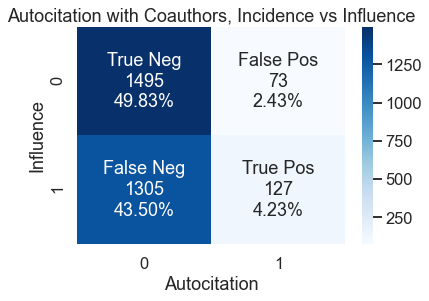

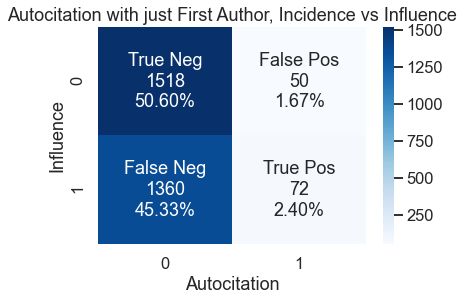

In [9]:
from scipy.stats.stats import pearsonr
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(len(coauthors))
print(len(totdf["citation_influence_label"].values))
print(sum(totdf["citation_influence_label"].values))

plt.figure()
plt.title("Autocitation with Coauthors, Incidence vs Influence")

cf_matrix = confusion_matrix(totdf["citation_influence_label"].values, coauthors)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Autocitation")
plt.ylabel("Influence")

plt.figure()
plt.title("Autocitation with just First Author, Incidence vs Influence")
cf_matrix = confusion_matrix(totdf["citation_influence_label"].values, firstauthors)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Autocitation")
plt.ylabel("Influence")


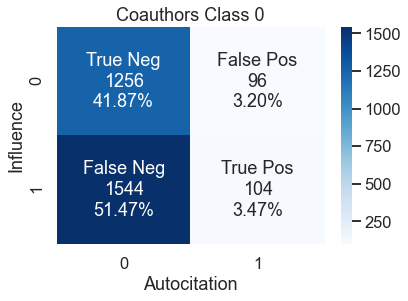

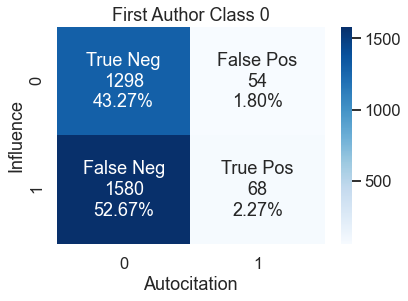

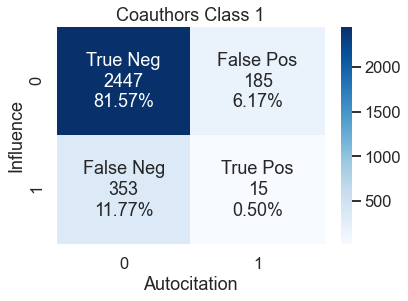

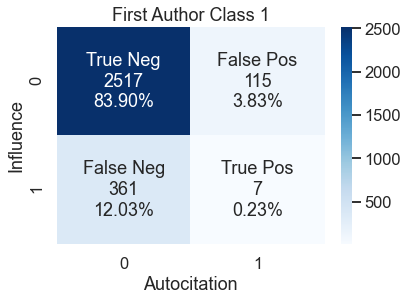

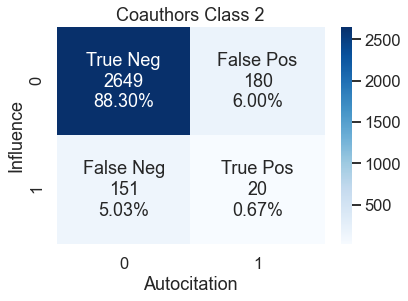

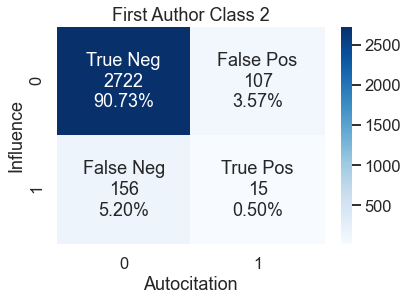

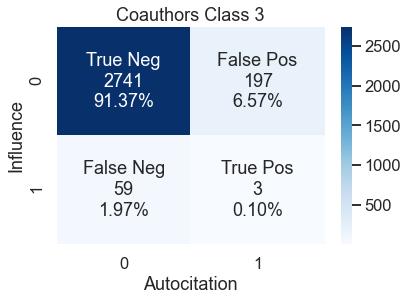

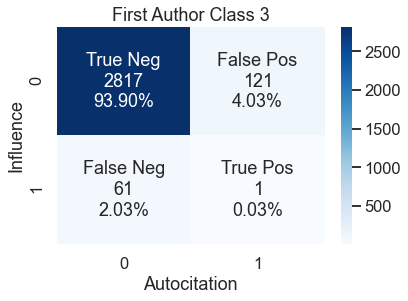

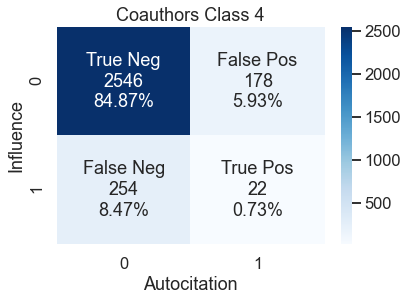

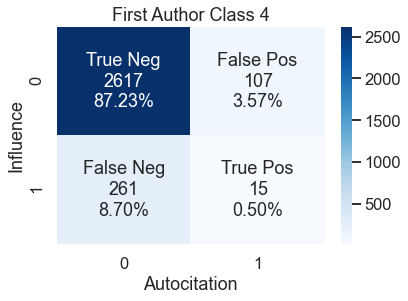

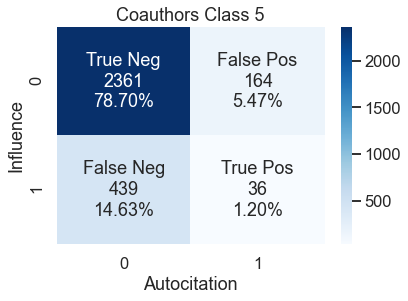

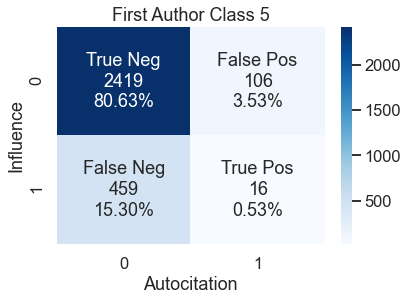

In [10]:
for i in range(6):
    plt.figure()
    plt.title(f"Coauthors Class {i}")
    onehot = totdf["citation_class_label"].values == i
    cf_matrix = confusion_matrix(onehot, coauthors)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Autocitation")
    plt.ylabel("Influence")

    plt.figure()
    plt.title(f"First Author Class {i}")
    cf_matrix = confusion_matrix(onehot, firstauthors)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Autocitation")
    plt.ylabel("Influence")


### Relative Position in Bibliography

Next, I wanted to explore whether the relative position of a reference in a bibliography. I hypothesize that a reference that occurs earlier in the bibliography is more influential, or reflect where the citation occurs in the full text (if the bibliography is ordered chronologically). An earlier citation could be more likely to be background, and a later citation could be more likely to be future. After generating a scalar feature [0,1], I then generate raw ROCs for it, as well as those after being put through a Random Forest Classifier.

In [11]:
proportions = []
# testproportions = []

for i, uniqueid in enumerate(totdf["unique_id"].values):
    UID = totdf.core_id.values[i]
    fullname = totdf.citing_author.values[i].split(" ")
    citing_author = fullname[1] + fullname[0][0]
    cleanedcitingauthor = re.sub(r'[^\w\s+]','',citing_author)
    cleanedcitinglast = re.sub(r'[^\w\s+]','', fullname[1])
    article = coreid2Article[UID]
    
    cited_title = totdf["cited_title"].values[i]
    cleanedcitedauthor = re.sub(r'[^\w\s+]','',totdf["cited_author"].values[i])
    regtitle =  re.sub(r'[^\w]','',cited_title[0:24])
    

    if "reference" in article["sections"].keys():
        firstauthors.append(0)
        fulltext = article["sections"]["reference"]["text"]
        regterm = re.sub(r'[^\w]','',fulltext)
#         if totdf["set"].values[i] != "test":
        proportion = regterm.find(regtitle)/len(regterm)
        proportions.append(proportion)
#             testproportions.append(-1)
#         else:
#             proportion = regterm.find(regtitle)/len(regterm)
#             testproportions.append(proportion)
#             proportions.append(-1)
    else:
        proportions.append(-1)
#         coauthors.append(0)
#         firstauthors.append(0)
totdf["proportions"] = proportions

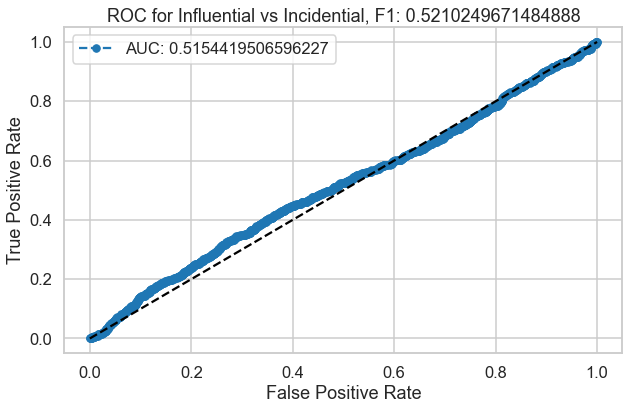

In [12]:
croppedf = totdf.loc[totdf["proportions"] > 0]

y_pred = croppedf["proportions"].values
y_true = croppedf["citation_influence_label"].values

binary_metrics(y_true, y_pred)

As we can see, the feature isn't very useful for the influential vs incidental case. I then investigate the multiclass scenario:

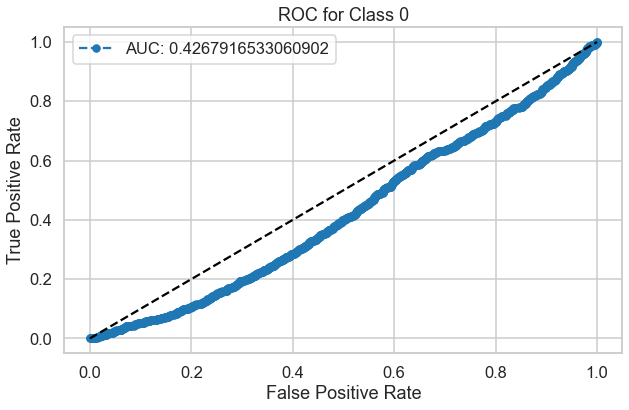

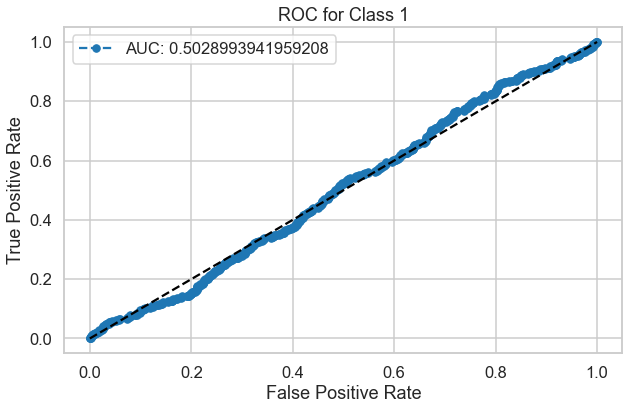

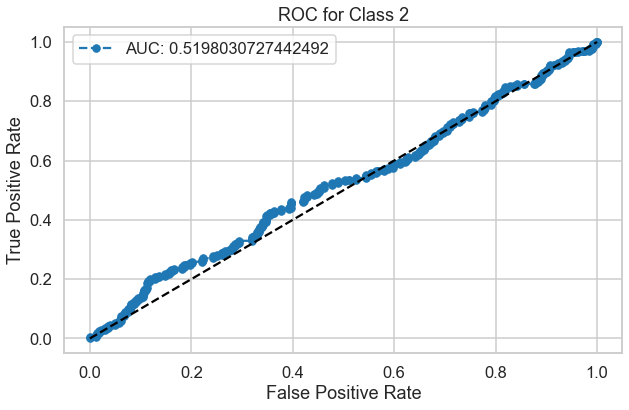

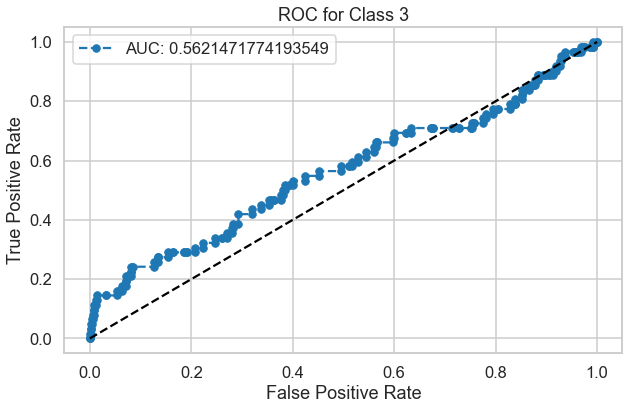

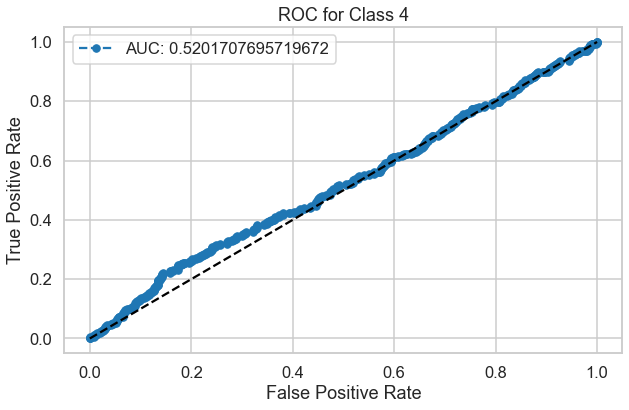

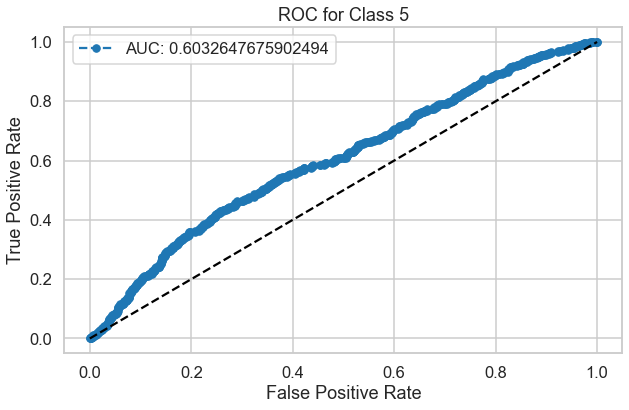

In [13]:
y_true = croppedf["citation_class_label"].values
for i in range(6):
    onehot = y_true == i
    binary_metrics(onehot, y_pred, output_text=False, title=i, filepath="")

Verification: Grid Search of parameter space using K-Fold CV on Random Forests to evaluate feature

In [14]:
traindf= totdf.loc[totdf["set"]=="train"]

parameters = {
    'n_estimators': [10,50,100],
    'max_depth': [None, 5,10,50,100],
    'ccp_alpha': [0.0, 0.5, 1.0]
}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring="f1_macro")
# clf = RandomForestClassifier()

X_train = traindf["proportions"].values.reshape((-1,1))
y_true = traindf["citation_influence_label"].values#.reshape((-1,1))
print(y_true.shape)
print(X_train.shape)
clf.fit(X_train, y_true)

(2528,)
(2528, 1)


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.5, 1.0],
                         'max_depth': [None, 5, 10, 50, 100],
                         'n_estimators': [10, 50, 100]},
             scoring='f1_macro')

In [15]:
testdf = totdf.loc[totdf["set"] == "test"]
y_test = clf.predict_proba(testdf["proportions"].values.reshape((-1, 1)))
y_true = testdf["citation_influence_label"].values.reshape((-1,1))

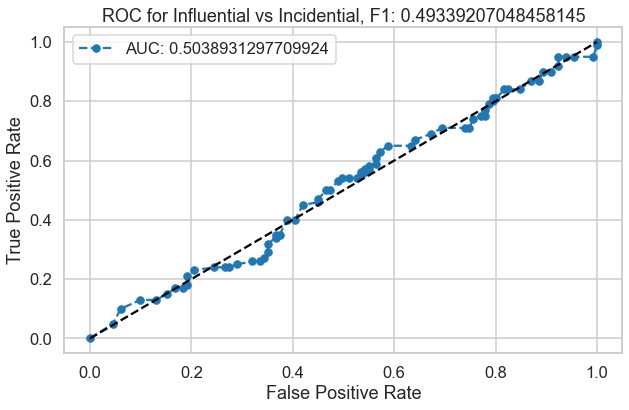

In [16]:
binary_metrics(y_true, y_test[:, 0])

### Multiclass test:

In [17]:
parameters = {
    'n_estimators': [10,50,100],
    'max_depth': [None, 5,10,50,100],
}

# traindf = totdf.loc[totdf["set"] == train]

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring="f1_macro")

X_train = traindf["proportions"].values.reshape((-1,1))
y_true = traindf["citation_class_label"].values#.reshape((-1,1))
clf.fit(X_train, y_true)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 50, 100],
                         'n_estimators': [10, 50, 100]},
             scoring='f1_macro')

In [18]:
X_test = testdf["proportions"].values.reshape((-1,1))
y_true = testdf["citation_class_label"].values
y_pred = clf.predict_proba(X_test)

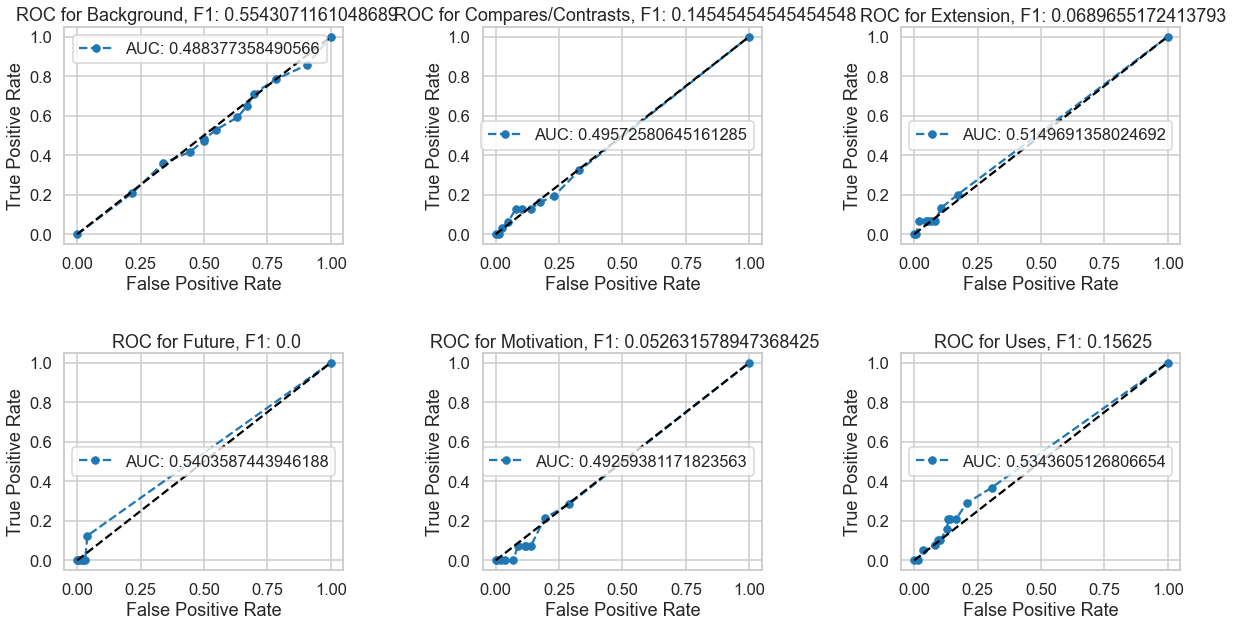

In [19]:
multiclass_metrics(y_true, y_pred, output_text=True, filepath="")